### Face detection and alignment

In [1]:
%useLatestDescriptors
%use kotlin-dl

Load and show image

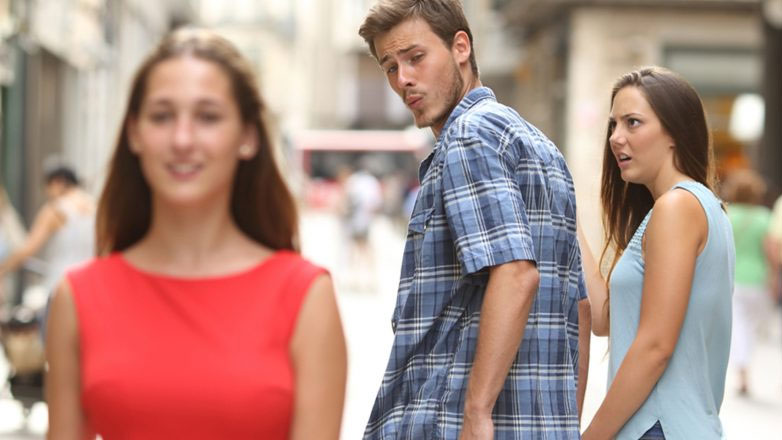

In [2]:
import java.io.File
import javax.imageio.ImageIO

val image = ImageIO.read(File("img.png"))
DISPLAY(image)

Create model hub

In [3]:
val modelHub = ONNXModelHub(cacheDirectory = File("cache/pretrainedModels"))

Download face detection model and print summary

In [4]:
val detectionModel = ONNXModels.FaceDetection.UltraFace320.pretrainedModel(modelHub)
detectionModel.printSummary()

UltraFace320 model summary
Model type: ONNX
____________________________________________________
Inputs  Type                                        
input   Tensor {dtype=FLOAT, shape [1, 3, 240, 320]}
____________________________________________________
Outputs Type                                        
scores  Tensor {dtype=FLOAT, shape [1, 4420, 2]}    
____________________________________________________
boxes   Tensor {dtype=FLOAT, shape [1, 4420, 4]}    
____________________________________________________


Download alignment model and print summary

In [5]:
val alignmentModel = ONNXModels.FaceAlignment.Fan2d106.pretrainedModel(modelHub)
alignmentModel.printSummary()

Fan2d106 model summary
Model type: ONNX
_____________________________________________________
Inputs  Type                                         
data    Tensor {dtype=FLOAT, shape [-1, 3, 192, 192]}
_____________________________________________________
Outputs Type                                         
fc1     Tensor {dtype=FLOAT, shape [1, 212]}         
_____________________________________________________


Detect faces on the image

In [6]:
val faces = detectionModel.use { it.detectFaces(image) }

Utility functions to draw on the image

In [7]:
import java.awt.Graphics2D
import java.awt.RenderingHints
import java.awt.image.BufferedImage

fun BufferedImage.copy(): BufferedImage {
    val result = BufferedImage(width, height, type)
    copyData(result.raster)
    return result
}

fun BufferedImage.draw(block: (Graphics2D) -> Unit): BufferedImage {
    return copy().also { image ->
        val graphics2D = image.createGraphics()
        try {
            graphics2D.setRenderingHint(RenderingHints.KEY_ANTIALIASING, RenderingHints.VALUE_ANTIALIAS_ON)
            block(graphics2D)
        } finally {
            graphics2D.dispose()
        }
    }
}

fun BufferedImage.x(x: Float) = (x * width).toInt()
fun BufferedImage.y(y: Float) = (y * height).toInt()

Resize image and draw detected faces

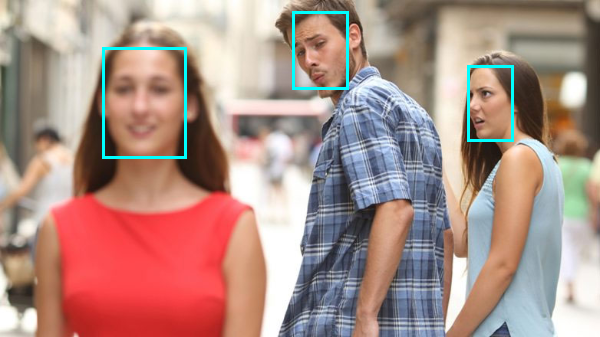

In [8]:
import java.awt.BasicStroke
import java.awt.Color

val width = 600
val resize = pipeline<BufferedImage>().resize {
    outputWidth = width
    outputHeight = width * image.height / image.width
}
val displayImage = resize.apply(image)
displayImage.draw { g ->
    g.color = Color.CYAN
    g.stroke = BasicStroke(3f)
    faces.forEach { face ->
        g.drawRect(
            displayImage.x(face.xMin), displayImage.y(face.yMin),
            displayImage.x(face.xMax) - displayImage.x(face.xMin),
            displayImage.y(face.yMax) - displayImage.y(face.yMin)
        )
    }
}

Utility function which makes an image crop for the detected object and runs inference on the crop

In [12]:
import org.jetbrains.kotlinx.dl.api.inference.FlatShape
import org.jetbrains.kotlinx.dl.api.inference.objectdetection.DetectedObject

fun <T : FlatShape<T>> OnnxHighLevelModel<BufferedImage, List<T>>.predictOnCrop(
    image: BufferedImage,
    detectedObject: DetectedObject
): List<T> {
    val objectWidth = detectedObject.xMax - detectedObject.xMin
    val objectHeight = detectedObject.yMax - detectedObject.yMin
    val x1 = ((detectedObject.xMin - 0.1f * objectWidth) * image.width).toInt().coerceAtLeast(0)
    val y1 = ((detectedObject.yMin - 0.1f * objectHeight) * image.height).toInt().coerceAtLeast(0)
    val x2 = ((detectedObject.xMax + 0.1f * objectWidth) * image.width).toInt().coerceAtMost(image.width)
    val y2 = ((detectedObject.yMax + 0.1f * objectHeight) * image.height).toInt().coerceAtMost(image.height)

    val cropImage = pipeline<BufferedImage>().crop {
        left = x1
        top = y1
        right = image.width - x2
        bottom = image.height - y2

    }.apply(image)

    return predict(cropImage).map { shape ->
        shape.map { x, y ->
            (x1 + x * cropImage.width) / image.width to
                    (y1 + y * cropImage.height) / image.height
        }
    }
}

Perform alignment on the faces

In [13]:
val facesToLandmarks = alignmentModel.use {
    faces.associateWith { face -> alignmentModel.predictOnCrop(image, face) }
}

Draw face landmarks on the image

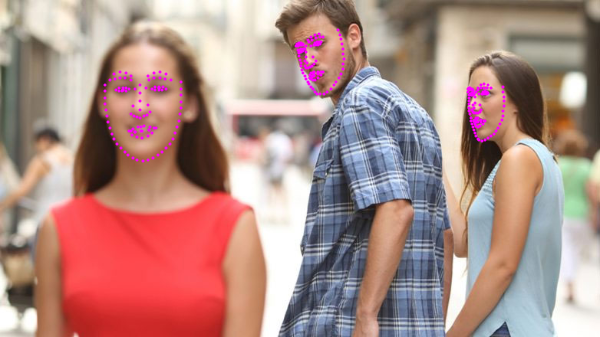

In [14]:
import java.awt.geom.Ellipse2D

val r = 1.5f
displayImage.draw { g ->
    g.color = Color.MAGENTA
    g.stroke = BasicStroke(2f)
    facesToLandmarks.forEach { _, landmarks ->
        landmarks.forEach { landmark ->
            g.fill(Ellipse2D.Float(displayImage.x(landmark.x) - r, displayImage.y(landmark.y) - r, 2 * r, 2 * r))
        }
    }
}